In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmpq3rc_3hz/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [3]:
import Foundation
import Just
import Path

In [4]:
public func FacesDataBunch(path: Path = mnistPath, bs: Int = 20)
   -> DataBunch<DataBatch<TF, TI>> {
    let tr_x = np.load((path/"trainX.npy").string).astype(np.float32) / 255.0
    let tr_y = np.load((path/"trainY.npy").string).astype(np.int32)
    let ts_x = np.load((path/"testX.npy").string).astype(np.float32) / 255.0
    let ts_y = np.load((path/"testY.npy").string).astype(np.int32)
    let xTrain = Tensor<Float>(ShapedArray<Float>(numpy: tr_x)!)
    let yTrain = Tensor<Int32>(ShapedArray<Int32>(numpy: tr_y)!)
    let xValid = Tensor<Float>(ShapedArray<Float>(numpy: ts_x)!)
    let yValid = Tensor<Int32>(ShapedArray<Int32>(numpy: ts_y)!)
    return DataBunch(train: Dataset(elements: DataBatch(xb:xTrain, yb: yTrain)), 
                     valid: Dataset(elements: DataBatch(xb:xValid, yb: yValid)),
                     trainLen: xTrain.shape[0],
                     validLen: xValid.shape[0],
                     bs: bs)
}


In [5]:
let d = FacesDataBunch(path: Path.home/"swift",bs: 40)

In [6]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [40, 10304]
  ▿ dimensions : 2 elements
    - 0 : 40
    - 1 : 10304


In [7]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid1: Int, nHid2: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid1, activation: relu)
        hidden2 = FADense(nHid1, nHid2, activation: relu)
        out =     FADense(nHid2, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [8]:
func modelInit() -> MyModel { return MyModel(nIn: 10304, nHid1: 512,nHid2: 512, nOut: 20) }

In [9]:
public let FacesStats = (mean: TF(0.4617096), std: TF(0.20259255))

In [10]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [11]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [12]:
func SGD_optFunc(_ model: MyModel) -> SGD<MyModel> { return SGD(for: model, learningRate: 0.01)}

let learner = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_optFunc, 
                    modelInit: modelInit)

let recorder_sgd = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [13]:
learner.fit(25)

Epoch 0: Train: [2.558047, 0.2625] , Valid:[1.8901901, 0.64375]            
Epoch 1: Train: [1.3744937, 0.80833334] , Valid:[1.2038932, 0.88125]      
Epoch 2: Train: [0.7369048, 0.95] , Valid:[0.8810255, 0.8625]             
Epoch 3: Train: [0.4180783, 0.9916667] , Valid:[0.68569577, 0.90625]      
Epoch 4: Train: [0.27508155, 1.0] , Valid:[0.59155196, 0.9125]            
Epoch 5: Train: [0.19514512, 1.0] , Valid:[0.5110701, 0.9125]             
Epoch 6: Train: [0.15033564, 1.0] , Valid:[0.48129234, 0.90625]           
Epoch 7: Train: [0.12113137, 1.0] , Valid:[0.42989054, 0.93125]           
Epoch 8: Train: [0.09645401, 1.0] , Valid:[0.4103902, 0.925]              
Epoch 9: Train: [0.08233585, 1.0] , Valid:[0.38907847, 0.93125]           
Epoch 10: Train: [0.07064411, 1.0] , Valid:[0.38308185, 0.925]            
Epoch 11: Train: [0.0612943, 1.0] , Valid:[0.36984503, 0.93125]           
Epoch 12: Train: [0.054748837, 1.0] , Valid:[0.356196, 0.925]             
Epoch 13: Train: [0.0486

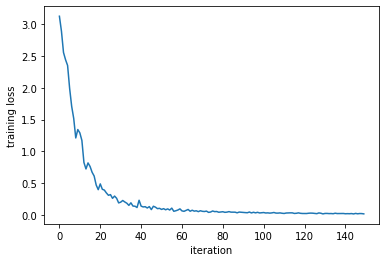

In [14]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [15]:
func SGD_nest_optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}
let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_optFunc, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [16]:
try! learner_nest.fit(25)

Epoch 0: Train: [2.6611283, 0.2625] , Valid:[2.0087955, 0.68125]          
Epoch 1: Train: [1.5248195, 0.775] , Valid:[1.3949267, 0.6875]            
Epoch 2: Train: [0.8788038, 0.9291667] , Valid:[0.9896568, 0.85]          
Epoch 3: Train: [0.5051026, 0.9875] , Valid:[0.71904504, 0.91875]         
Epoch 4: Train: [0.3188109, 1.0] , Valid:[0.6185479, 0.90625]             
Epoch 5: Train: [0.23099206, 1.0] , Valid:[0.5326818, 0.925]              
Epoch 6: Train: [0.167954, 1.0] , Valid:[0.46305108, 0.9375]              
Epoch 7: Train: [0.13499422, 1.0] , Valid:[0.4282454, 0.93125]            
Epoch 8: Train: [0.10748402, 1.0] , Valid:[0.3980104, 0.93125]            
Epoch 9: Train: [0.091716036, 1.0] , Valid:[0.37548292, 0.93125]          
Epoch 10: Train: [0.078994915, 1.0] , Valid:[0.35856676, 0.93125]         
Epoch 11: Train: [0.06914268, 1.0] , Valid:[0.34011433, 0.9375]           
Epoch 12: Train: [0.060756214, 1.0] , Valid:[0.32465452, 0.9375]          
Epoch 13: Train: [0.05390

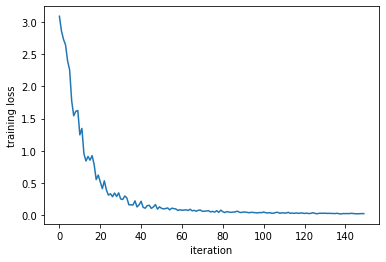

In [17]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [18]:
//Optimizer with Nesterov step and L1 regularizer
func Nest_L1_optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: Nest_L1_optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [19]:
learner_nest_l1.fit(25)

Epoch 0: Train: [2.6362183, 0.27916667] , Valid:[1.9923929, 0.50625]      
Epoch 1: Train: [1.5286063, 0.71666664] , Valid:[1.3590093, 0.74375]      
Epoch 2: Train: [0.87946445, 0.9166667] , Valid:[0.9832252, 0.86875]      
Epoch 3: Train: [0.48657563, 1.0] , Valid:[0.7528238, 0.8875]             
Epoch 4: Train: [0.3100877, 1.0] , Valid:[0.6097392, 0.91875]             
Epoch 5: Train: [0.21476789, 1.0] , Valid:[0.51327264, 0.93125]           
Epoch 6: Train: [0.15877007, 1.0] , Valid:[0.46809083, 0.93125]           
Epoch 7: Train: [0.12689516, 1.0] , Valid:[0.43597174, 0.9375]            
Epoch 8: Train: [0.100949354, 1.0] , Valid:[0.40297985, 0.9375]           
Epoch 9: Train: [0.08521651, 1.0] , Valid:[0.38000232, 0.9375]            
Epoch 10: Train: [0.07332698, 1.0] , Valid:[0.3678738, 0.93125]           
Epoch 11: Train: [0.064178385, 1.0] , Valid:[0.3521874, 0.9375]           
Epoch 12: Train: [0.057056937, 1.0] , Valid:[0.34127694, 0.9375]          
Epoch 13: Train: [0.05093

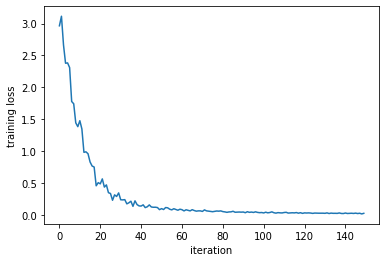

In [20]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [21]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: FacesStats.mean, std: FacesStats.std)])

In [22]:
learner_nest_l2.fit(25)

Epoch 0: Train: [2.3263521, 0.33333334] , Valid:[1.2513549, 0.6875]       
Epoch 1: Train: [0.44128665, 0.90416664] , Valid:[0.5560625, 0.84375]     
Epoch 2: Train: [0.06527206, 0.9916667] , Valid:[0.3411185, 0.91875]      
Epoch 3: Train: [0.02129594, 0.99583334] , Valid:[0.31714275, 0.925]      
Epoch 4: Train: [0.0020046579, 1.0] , Valid:[0.4086176, 0.90625]          
Epoch 5: Train: [0.0031277463, 1.0] , Valid:[0.43284506, 0.9125]          
Epoch 6: Train: [0.0011792985, 1.0] , Valid:[0.42213106, 0.9125]          
Epoch 7: Train: [0.00037078033, 1.0] , Valid:[0.41557112, 0.9125]         
Epoch 8: Train: [0.00024308804, 1.0] , Valid:[0.40966773, 0.91875]        
Epoch 9: Train: [0.00020606213, 1.0] , Valid:[0.40295172, 0.91875]        
Epoch 10: Train: [0.00018382957, 1.0] , Valid:[0.39533323, 0.91875]       
Epoch 11: Train: [0.00017143902, 1.0] , Valid:[0.38916522, 0.91875]       
Epoch 12: Train: [0.00015642119, 1.0] , Valid:[0.3837567, 0.91875]        
Epoch 13: Train: [0.00014

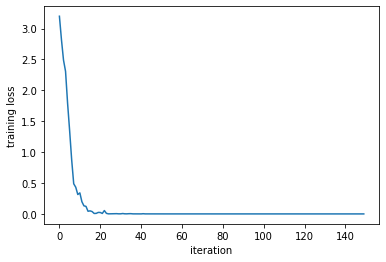

In [23]:
recorder_nest_l2.plotLosses()

In [24]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [25]:
func smooth_curve(points:Array<Float>, factor:Float=0.99) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

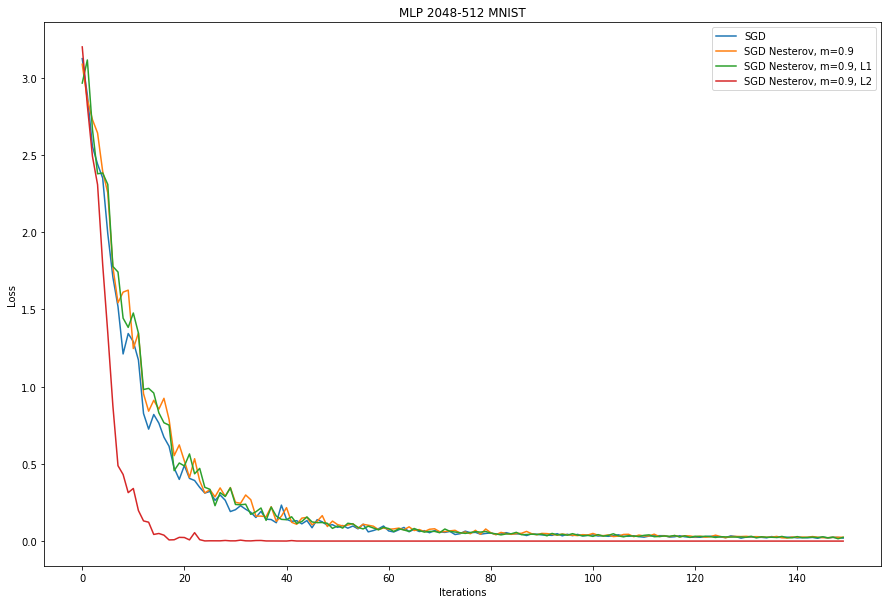

None


In [26]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 150
let y2 = Array(y[i..<n])
plt.plot(y2,Array(sgd[i..<n]), label:"SGD")
plt.plot(y2,Array(nest[i..<n]), label:"SGD Nesterov, m=0.9")
plt.plot(y2,Array(nest_l1[i..<n]), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,Array(nest_l2[i..<n]), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 2048-512 MNIST")
plt.show()